In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def add_arrow(line, position=None, direction='right', size=30, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, linewidth=3),
        size=size
    )

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
76 packages can be upgraded. Run 'ap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def dX_dt(X, Y, sys_eq, t=0): return map(eval, sys_eq)

def plot_ode(sys_eq, norm_size=True, xrange=[-5, 5], yrange=[-5, 5], grid=[21, 21], cmap='inferno', show_arrow=True):
    """
    Plot the direction field for an ODE written in the form 
        x' = F(x,y)
        y' = G(x,y)
    
    The functions F,G are defined in the list of strings sys_eq.
    
    Input
    -----
    sys_eq: list of strings ["F(X,Y)", "G(X,Y)"
            F,G are functions of X and Y (capitals).
            poleq_1 = ["0.3*X-0.5*np.abs(X)+-0.3*Y+0.1*np.abs(Y)", "0.3*X+0.5*np.abs(X)+0.3*Y+0.5*np.abs(Y)"]
    xrange: list [xmin, xmax] (optional)
    yrange: list [ymin, ymax] (optional)
    grid:   list [npoints_x, npoints_y] (optional)
            Defines the number of points in the x-y grid.
    cmap:  string (optional)
            Color for the vector field (https://matplotlib.org/tutorials/colors/colormaps.html)
            coolwarm, autumn, inferno, magma, YlOrRd, OrRd, BuPu, Greens
    Full Credit to https://gist.github.com/nicoguaro/6767643
    """
    x = np.linspace(xrange[0], xrange[1], grid[0])
    y = np.linspace(yrange[0], yrange[1], grid[1])
    
    X , Y  = np.meshgrid(x, y)   # create a grid
    DX, DY = dX_dt(X, Y, sys_eq) # compute growth rate on the grid
    M = (np.hypot(DX, DY))       # Norm of the growth rate 
    M[M == 0] = 1                # Avoid zero division errors 
    if norm_size:                     # Normalize each arrows
        DX = DX/M                    
        DY = DY/M
        
    fig = plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='w')
    plt.quiver(X, Y, DX, DY, M, pivot='mid',cmap=cmap)  # plot vector field
    
    # Visualization ===================
    plt.xlim(xrange), plt.ylim(yrange) # control xy range
    plt.grid(False) # no grid
    plt.axhline(linewidth=4, color='k')  # horizontal axis
    plt.axvline(linewidth=4, color='k')  # vertical axis
    for spine in plt.gca().spines.values(): # set frame to invisible #https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
        spine.set_visible(False)
    plt.xticks([])
    plt.yticks([]) # turn off xtick
    if show_arrow:
        plt.arrow(0.003, 4.86, 0, 0.1, width=0.015, color="k", clip_on=False, head_width=0.17, head_length=0.17)
        plt.arrow(0.003, -4.86, 0, -0.1, width=0.015, color="k", clip_on=False, head_width=0.17, head_length=0.17)
        plt.arrow(4.8, 0, 0.1, 0., width=0.015, color="k", clip_on=False, head_width=0.17, head_length=0.17)
        plt.arrow(-4.8, 0, -0.1, 0., width=0.015, color="k", clip_on=False, head_width=0.17, head_length=0.17)

In [3]:
def var_to_eq(a,b,c,d,p,q,r,s):
    return [str((a+b)/2)+"*X+"+str((a-b)/2)+"*np.abs(X)+"+str((c+d)/2)+"*Y+"+str((c-d)/2)+"*np.abs(Y)", 
            str((p+q)/2)+"*X+"+str((p-q)/2)+"*np.abs(X)+"+str((r+s)/2)+"*Y+"+str((r-s)/2)+"*np.abs(Y)"]

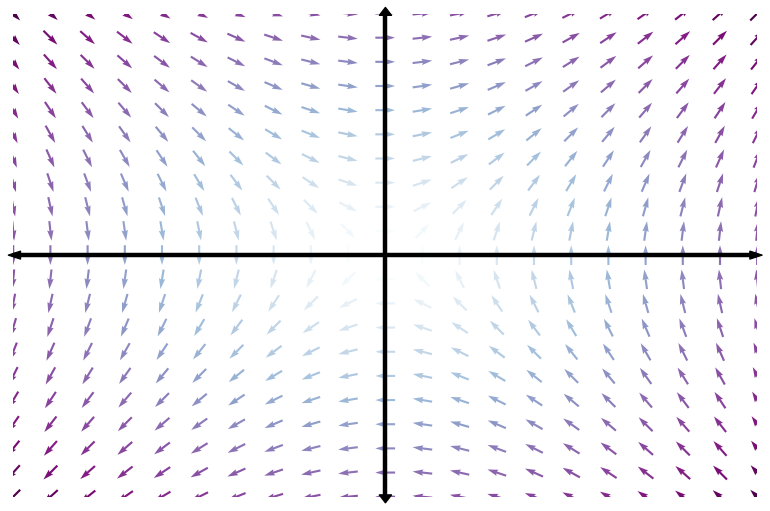

In [4]:
plot_ode(var_to_eq(0,0,1,1, 1,1,0,0), norm_size=True, xrange=[-5, 5], yrange=[-5, 5], cmap='BuPu')
plt.show()

In [27]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/'My Drive'/Chula/publication/bargain_game
  %pip install -e gym-bargain
else:
  !pip install -e gym-bargain

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Chula/publication/bargain_game
Obtaining file:///gdrive/My%20Drive/Chula/publication/bargain_game/gym-bargain
  Found existing installation: gym-bargain 0.0.1
    Can't uninstall 'gym-bargain'. No files were found to uninstall.
  Running setup.py develop for gym-bargain


In [9]:
import gym
env = gym.make('gym_bargain:one-rl-agent-v0')

env.seed(42)
obs = env.reset()

action = [1,1,0.5,0.5]  # 1,1,0.5,0.5
obs, reward, done, info = env.step(action)
obs

## Opponent with static strategy: Deep Reinforcement Learning with Monte-Carlo  Policy Gradient

In [11]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        action_proba = model(obs[np.newaxis])
        a_proba, b_proba, c_proba, d_proba = model(obs[np.newaxis]).numpy().flatten()
        a_action = np.percentile(tf.random.uniform([1, 100]), a_proba*100)
        b_action = np.percentile(tf.random.uniform([1, 100]), b_proba*100)
        c_action = np.percentile(tf.random.uniform([1, 100]), c_proba*100)
        d_action = np.percentile(tf.random.uniform([1, 100]), d_proba*100)

        y_target = tf.constant([[a_action, b_action, c_action, d_action]])
        loss= tf.reduce_mean(loss_fn(y_target, action_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step([a_action, b_action, c_action, d_action])
    return obs, reward, done, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [14]:
import gym
env = gym.make('gym_bargain:one-rl-agent-v0')

env.seed(42)
obs = env.reset()

n_iterations = 5
n_episodes_per_update = 20
n_max_steps = 2000
discount_rate = 0.99

save_every_iter = 10

In [ ]:
dir_save_model = "01_model/01_01_dis99_iminfo_one_agent"
try: os.makedirs(dir_save_model)
except: pass

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

model = keras.models.Sequential([
    keras.layers.Dense(12, activation="elu", input_shape=[2]),
    keras.layers.Dense(12, activation="elu"), 
    keras.layers.Dense(12, activation="elu"),
    keras.layers.Dense(4, activation="sigmoid")
])

In [16]:
env = gym.make('gym_bargain:one-rl-agent-v0')
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    if iteration%save_every_iter==0: 
        model.save(os.path.join(dir_save_model, "model_iter"+str(int(iteration)).zfill(4)+".h5"))
        
env.close()
model.save(os.path.join(dir_save_model, "model_iter_final.h5"))

Iteration: 4, mean rewards: -136.1

### Plot strategy and bargain space

In [21]:
static_strategy=False

obs = env.reset()
done = False
count_step = 0

while not done:
  if static_strategy:
    action = [0.5,0.5,1,1]  # 1,1,0.5,0.5
    obs, reward, done, info = env.step(action)
  else:
    action = model(obs[np.newaxis]).numpy().flatten()
    obs, reward, done, info = env.step(action)
  if count_step==0:
    obs_1epi = obs.reshape(1,2)
    action_1epi = action.reshape(1,4)
  else: 
    obs_1epi = np.concatenate((obs_1epi, obs.reshape(1,2)), axis=0)
    action_1epi = np.concatenate((action_1epi, action.reshape(1,4)), axis=0)
  count_step+=1
print(count_step)

592


['0.0*X+0.0*np.abs(X)+1.0*Y+0.0*np.abs(Y)', '1.0*X+0.0*np.abs(X)+0.0*Y+0.0*np.abs(Y)']


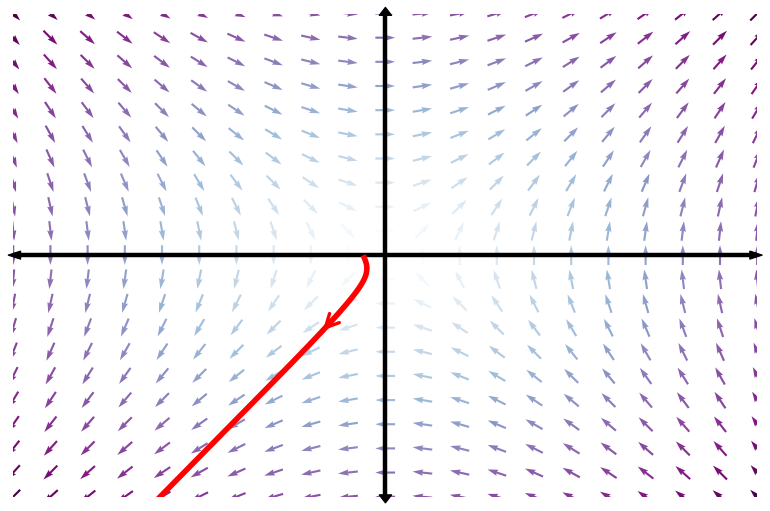

In [22]:
eq = var_to_eq(0,0,1,1,
               1,1,0,0)
print(eq)

plot_ode(eq, norm_size=True, xrange=[-5, 5], yrange=[-5, 5], cmap='BuPu')
line = plt.plot(pd.DataFrame(obs_1epi)[0], pd.DataFrame(obs_1epi)[1], 'r', linewidth=5)[0]
add_arrow(line)
plt.show()

In [204]:
strategy_df = pd.melt((pd.DataFrame(action_1epi, columns=['a','b', 'c', 'd'])*2-1).reset_index(), id_vars='index')
strategy_df_col_name_dict = {'index': 'Time Steps', 'variable':'Strategy Variables', 'value':'Strategy Value'}
strategy_df = strategy_df.rename(columns=strategy_df_col_name_dict)

alt.Chart(strategy_df).mark_line().encode(
  x=strategy_df_col_name_dict['index'],
  y=strategy_df_col_name_dict['value'],
  color=strategy_df_col_name_dict['variable']
).interactive(bind_y=False)

alt.Chart(...)

## Deep Reinforement Learning: Multi-Agents with Imperfect Information

In [26]:
def play_one_step(env, obs, model1, model2, loss_fn):
    with tf.GradientTape() as tape1:
        action_proba1 = model1(obs[np.newaxis])
        a_proba, b_proba, c_proba, d_proba = model1(obs[np.newaxis]).numpy().flatten()
        a_action = np.percentile(tf.random.uniform([1, 100]), a_proba*100)
        b_action = np.percentile(tf.random.uniform([1, 100]), b_proba*100)
        c_action = np.percentile(tf.random.uniform([1, 100]), c_proba*100)
        d_action = np.percentile(tf.random.uniform([1, 100]), d_proba*100)

        y_target1 = tf.constant([[a_action, b_action, c_action, d_action]])
        loss1 = tf.reduce_mean(loss_fn(y_target1, action_proba1))
    grads1 = tape1.gradient(loss1, model1.trainable_variables)
    
    with tf.GradientTape() as tape2:
        action_proba2 = model2(obs[np.newaxis])
        p_proba, q_proba, r_proba, s_proba = model2(obs[np.newaxis]).numpy().flatten()
        p_action = np.percentile(tf.random.uniform([1, 100]), p_proba*100)
        q_action = np.percentile(tf.random.uniform([1, 100]), q_proba*100)
        r_action = np.percentile(tf.random.uniform([1, 100]), r_proba*100)
        s_action = np.percentile(tf.random.uniform([1, 100]), s_proba*100)

        y_target2 = tf.constant([[p_action, q_action, r_action, s_action]])
        loss2 = tf.reduce_mean(loss_fn(y_target2, action_proba2))

    grads2 = tape2.gradient(loss2, model2.trainable_variables)
    grads_n = [grads1, grads2]
    obs, reward_n, done, info = env.step([[a_action, b_action, c_action, d_action], [p_action, q_action, r_action, s_action]])
    return obs, reward_n, done, grads_n

def play_multiple_episodes(env, n_episodes, n_max_steps, model1, model2, loss_fn):
    all_rewards1 = []
    all_grads1 = []
    all_rewards2 = []
    all_grads2 = []

    for episode in range(n_episodes):
        current_rewards1 = []
        current_grads1 = []
        current_rewards2 = []
        current_grads2 = []

        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward_n, done, grads_n = play_one_step(env, obs, model1, model2, loss_fn)
            current_rewards1.append(reward_n[0])
            current_grads1.append(grads_n[0])

            current_rewards2.append(reward_n[1])
            current_grads2.append(grads_n[1])
            if done:
                break
        all_rewards1.append(current_rewards1)
        all_grads1.append(current_grads1)

        all_rewards2.append(current_rewards2)
        all_grads2.append(current_grads2)
    return all_rewards1, all_grads1, all_rewards2, all_grads2

def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [31]:
import gym
env = gym.make('gym_bargain:two-rl-agent-v0')

env.seed(42)
obs = env.reset()

n_iterations = 15
n_episodes_per_update = 20
n_max_steps = 2000
discount_rate = 0.99

save_every_iter = 10

In [ ]:
dir_save_model = "01_model/01_02_dis99_iminfo_two_agent"
try: os.makedirs(dir_save_model)
except: pass

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

optimizer1 = keras.optimizers.Adam(lr=0.01)
optimizer2 = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

model1 = keras.models.Sequential([
    keras.layers.Dense(12, activation="elu", input_shape=[2]),
    keras.layers.Dense(12, activation="elu"), 
    keras.layers.Dense(12, activation="elu"),
    keras.layers.Dense(4, activation="sigmoid")
])

model2 = keras.models.Sequential([
    keras.layers.Dense(12, activation="elu", input_shape=[2]),
    keras.layers.Dense(12, activation="elu"), 
    keras.layers.Dense(12, activation="elu"),
    keras.layers.Dense(4, activation="sigmoid")
])

In [29]:
env = gym.make('gym_bargain:two-rl-agent-v0')
env.seed(42);

for iteration in range(n_iterations):
    all_rewards1, all_grads1, all_rewards2, all_grads2 = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model1, model2, loss_fn)
    total_rewards1 = sum(map(sum, all_rewards1))  
    total_rewards2 = sum(map(sum, all_rewards2))                      
    print("\rIteration: {}, mean rewards1: {:.1f}".format(iteration, total_rewards1 / n_episodes_per_update), end="")
    print("Iteration: {}, mean rewards2: {:.1f}".format(iteration, total_rewards2 / n_episodes_per_update), end="")
    all_final_rewards1 = discount_and_normalize_rewards(all_rewards1, discount_rate)
    all_final_rewards2 = discount_and_normalize_rewards(all_rewards2, discount_rate)

    all_mean_grads1 = []
    all_mean_grads2 = []
    for var_index in range(len(model1.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads1[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards1)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads1.append(mean_grads)
    
    for var_index in range(len(model2.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads2[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards2)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads2.append(mean_grads)

    optimizer1.apply_gradients(zip(all_mean_grads1, model1.trainable_variables))
    optimizer2.apply_gradients(zip(all_mean_grads2, model2.trainable_variables))

    if iteration%save_every_iter==0: 
        model1.save(os.path.join(dir_save_model, "model1_iter"+str(int(iteration)).zfill(4)+".h5"))
        model2.save(os.path.join(dir_save_model, "model2_iter"+str(int(iteration)).zfill(4)+".h5"))

env.close()
model1.save(os.path.join(dir_save_model, "model1_iter_final.h5"))
model2.save(os.path.join(dir_save_model, "model2_iter_final.h5"))

Iteration: 14, mean rewards2: 312.2

In [78]:
model1_load = keras.models.load_model(os.path.join(dir_save_model, "model1_iter_final.h5"), compile=False) # https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c
model2_load = keras.models.load_model(os.path.join(dir_save_model, "model2_iter_final.h5"), compile=False)

### Plot strategy and bargain space

In [72]:
count_step = 0
while count_step<1000:

  obs = env.reset()
  done = False
  
  while not done:
    action1 = model1_load(obs[np.newaxis]).numpy().flatten()
    action2 = model2_load(obs[np.newaxis]).numpy().flatten()
    obs, reward, done, info = env.step([action1, action2])
    if count_step==0:
      obs_1epi = obs.reshape(1,2)
      action1_1epi = action1.reshape(1,4)
      action2_1epi = action2.reshape(1,4)
    else: 
      obs_1epi = np.concatenate((obs_1epi, obs.reshape(1,2)), axis=0)
      action1_1epi = np.concatenate((action1_1epi, action1.reshape(1,4)), axis=0)
      action2_1epi = np.concatenate((action2_1epi, action2.reshape(1,4)), axis=0)
    count_step+=1
  print(count_step)

328
470
549
708
1923


['0.0*X+0.0*np.abs(X)+1.0*Y+0.0*np.abs(Y)', '1.0*X+0.0*np.abs(X)+0.0*Y+0.0*np.abs(Y)']


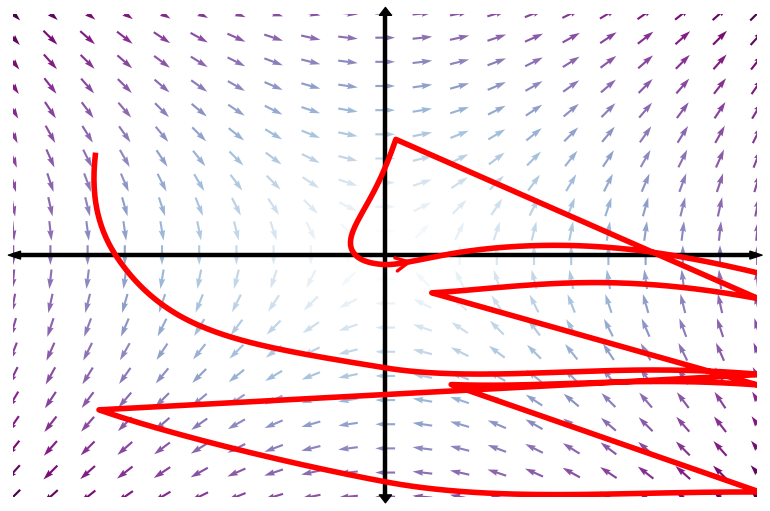

In [73]:
eq = var_to_eq(0,0,1,1,
               1,1,0,0)
print(eq)

plot_ode(eq, norm_size=True, xrange=[-5, 5], yrange=[-5, 5], cmap='BuPu')
line = plt.plot(pd.DataFrame(obs_1epi)[0], pd.DataFrame(obs_1epi)[1], 'r', linewidth=5)[0]
add_arrow(line)
plt.show()

In [76]:
alt.data_transformers.disable_max_rows() #https://altair-viz.github.io/user_guide/faq.html

strategy_df_col_name_dict = {'index': 'Time Steps', 'variable':'Strategy Variables', 'value':'Strategy Value'}

strategy1_df = pd.melt((pd.DataFrame(action1_1epi, columns=['a','b', 'c', 'd'])*2-1).reset_index(), id_vars='index').rename(columns=strategy_df_col_name_dict)
strategy2_df = pd.melt((pd.DataFrame(action2_1epi, columns=['p','q', 'r', 's'])*2-1).reset_index(), id_vars='index').rename(columns=strategy_df_col_name_dict)

abcd = alt.Chart(strategy1_df).mark_line().encode(
  x=strategy_df_col_name_dict['index'],
  y=strategy_df_col_name_dict['value'],
  color=strategy_df_col_name_dict['variable']
).interactive(bind_y=False)
abcd

alt.Chart(...)

In [77]:
pqrs = alt.Chart(strategy2_df).mark_line(strokeDash=[1,1]).encode(
  x=strategy_df_col_name_dict['index'],
  y=strategy_df_col_name_dict['value'],
  color=strategy_df_col_name_dict['variable']
).interactive(bind_y=False)
pqrs

alt.Chart(...)